## Imports & Setup

In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, Compose, Resize, RandomHorizontalFlip
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from helpers import *
from architecture.AutoEncoder import *
from torch.autograd import Variable

In [2]:
torch.manual_seed(969)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Prepare Dataset

In [4]:
def create_subsets(root, transformation):
    dataset = ImageFolder(root, transformation)
    train, test, val = torch.utils.data.random_split(dataset, [0.8, 0.1, 0.1])
    return train, test, val

In [5]:
size = 44
batch_size = 128
transformation = Compose([RandomHorizontalFlip(), Resize((size, size)), ToTensor()])

In [6]:
root = 'expanded_dataset/cropped_not_aug'
train_data, test_data, val_data = create_subsets(root, transformation)
data_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle = True)

## Initialize Autoencoder

In [7]:
def create_adam_optimizer(model, lr = 0.1, betas=(0.9, 0.999), amsgrad=False):
    return optim.Adam(model.parameters(), lr = lr, amsgrad=amsgrad, betas=betas)

In [8]:
# number of hidden layers and their sizes
hidden = [3, 32, 64, 128, 256]

# kernel size of convolution layers
kernel_size = 3

In [9]:
autoencmodel = AutoEncoder(hidden, kernel_size).to(device)
print(autoencmodel)

AutoEncoder(
  (enc_combined): Sequential(
    (0): Encoder(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
      (batchnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): LeakyReLU(negative_slope=0.01)
    )
    (1): Encoder(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
      (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): LeakyReLU(negative_slope=0.01)
    )
    (2): Encoder(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
      (batchnorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): LeakyReLU(negative_slope=0.01)
    )
    (3): Encoder(
      (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
      (batchnorm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): LeakyReLU(negative_slope=0.01)
    )
  )
  (dec_combined): Seq

## Train the AutoEncoder

In [10]:
outputs_list = []
loss_list = []
criterion = nn.MSELoss()
optimizer = create_adam_optimizer(autoencmodel, lr=0.001)

In [21]:
outputs_list = []

In [22]:
num_epochs = 2
for epoch in range(num_epochs):
    for data in data_loader:
        
        # Send data to device
        img, _ = data
        img = Variable(img).to(device)
        
        # Forward pass
        output = autoencmodel(img)
        loss = criterion(output, img)
        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # Display
    print('epoch {}/{}, loss {:.4f}'.format(epoch + 1, num_epochs, loss.item()))
    outputs_list.append((epoch, img, output),)
    loss_list.append(loss.item())

epoch 1/2, loss 0.0062
epoch 2/2, loss 0.0030


## Visualize AutoEncoder Outputs

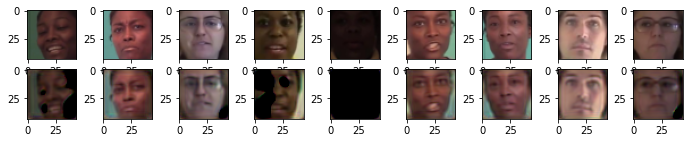

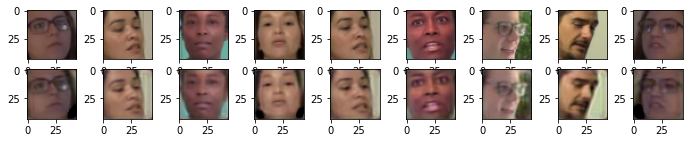

In [23]:
#display decoded images
from numpy import clip
for k in range(0, num_epochs):
    plt.figure(figsize = (12, 2))
    imgs = outputs_list[k][1].cpu().detach().numpy()
    recon = outputs_list[k][2].cpu().detach().numpy()
    
    for i, item in enumerate(imgs):
        if i >= 9: break
        item = item.swapaxes(0,1)
        item = item.swapaxes(1,2)
        item = clip(item, 0, 1)
        plt.subplot(2, 9, i+1)
        plt.imshow(item)
        
    for i, item in enumerate(recon):
        if i >= 9: break
        item = item.swapaxes(0,1)
        item = item.swapaxes(1,2)
        item = clip(item, 0, 1)
        plt.subplot(2, 9, 9+i+1)
        plt.imshow(item)

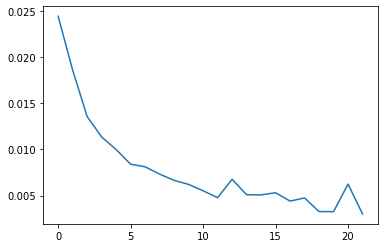

In [24]:
plt.figure()
plt.plot(loss_list)
plt.show()

In [18]:
len(loss_list)

20

## Saving Model

In [54]:
torch.save({'model_state_dict': autoencmodel.state_dict(), 
            'optimizer_state_dict': optimizer.state_dict()}, 
           './autoencoder256_27epochs')